In [0]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from math import sqrt, exp, log
import matplotlib.pyplot as plt
import random
import numba

# Numerical Procedure

## Given $S$

The binary or digital option is the derivative being studied here. 

$
\hspace 2em
\begin{equation}
Payoff(S)= \mathcal{H}(S)= 
    \begin{cases}
    1 \quad \phantom{1}  \text{if}\,\, S_T > 0  \\
    0 \quad \phantom{0}  otherwise \\
      \end{cases}
\end{equation}   
$

<br/>

$
\hspace 2em
\begin{equation}
V(S,t) = e^{-r(T-t)}\mathbb{E}^{\mathbb{Q}}[Payoff(S_T)]
\end{equation} 
$
<br/>

the closed form solution using the Black-Scholes-Merton model is:

</br>
$
\hspace 2em
\begin{equation}
V(S,t) = e^{-r(T-t)}N(d_2)
\end{equation} 
$



## Step 0: Employ Analytical Solution

Here, we will use our analytical solution to the Black Scholes Model

- $C = e^{-rT}\Phi(d_{2})$ (Digitial Call Option)
- $P = e^{-rT}\Phi(-d_{2})$ (Digial Put Option)

Where,

- $d_2 = \frac{log(S/E) + (r - D - \frac{1}{2}\sigma^2)(T - t)}{\sigma\sqrt{T - t}}$

Subsitiuting our values, we get:
- $d_2 = \frac{ln(100/100) + (0.05 - 0.5(0.2^2)(1 - 0))}{0.2\sqrt{1 - 0}}$

And $D = 0$,

Leading to,

- $d_2 = 0.15$


Using $d_2$, we can input this value into the call and put models to get:
- Binary Call Option = $0.532324815$
- Binary Put Option = $0.4189046$

With all this said, this analysis is purely deterministic, and does not take into account random variables. These values will be used to benchmark our analysis moving forward.


## Step 1: Monte Carlo Simulations via Forward Euler-Maruyama Scheme

---

Let 

$\hspace 4em  T = $Expiry Date (number of years)

$\hspace 4em  M = step Size$

$\hspace 4em N = 1000$  

$N$ = no. of iterations 

$\hspace 4em   \delta t = T/N$ 

$\hspace 4em  $divide a time interval $[0, T]$ into $N$

<br/>

##$\underline{ Brownian}$

$\hspace 2em  t_n = n · \delta t = n \frac{T}{N};\hspace 2em where \hspace 1em  n = 0, . . . , N \\ $

> we can simulate its values at the selected points by


$\hspace 4em  W_{t_{n+1}} = W_{t_n} + \Delta W_n,\hspace 4em W_{t_0} = W_0 = 0$

where $\Delta W_n$ are independent random variables with distribution $N(0, \delta t)$.

> Let


$\hspace 4em N[0..N-1]$ an array of $N$ independent draws from $N(0,1)$

$\hspace 4em For\hspace 1em  n = 0, 1, ..., N-1$

$\hspace 6em W_{n+1} = W_n + \sqrt{\delta}_t  N_n$

$\hspace 4em W_0 = 0 $

<br/>


### $\underline{Euler-Maruyama (EM)}$


$\hspace 4em For \hspace 1em n = 0, 1, ..., N-1$

$\hspace 6em S_{n+1} = S_n+ S_nr{\delta}t + S_n\sigma (W_{n+1} - W_n))$

<br/>

$\hspace 4em For \hspace 1em i=1, 2, ..., m$

$\hspace 6em S_T = $price at $'T'$ simulated with the Euler-Maruyama algorithm

$\hspace 6em C_m = h(S_T)$

<br/>

$\hspace 4em C = C_1 + . . . + C_m$

$\hspace 4em price = \frac{C}{m}$

Result: the price




In [0]:
@numba.njit(fastmath=True)
def generate_brownian_for(N):
    dt = 1./N  # slice the time into N steps
    arr_brownian = np.random.normal(0., 1., int(N))*np.sqrt(dt)  # genearate for each time step
    W = np.cumsum(arr_brownian) #  this gives the brownian path
    return W, arr_brownian
  

In [0]:
# Euler Maruyama Approximation
@numba.njit(fastmath=True)
def euler_maruyama_approximation(initial_S, riskfree_rate, sigma, arr_brownian, T, n_time_steps, step_size):
    dt = step_size * (1/n_time_steps)  # EM step size
    L = n_time_steps/step_size 
    
    Wi = [initial_S]
    for i in range(0,int(L)):
      start_idx = step_size*(i-1)+step_size
      end_idx = step_size*i + step_size
      Winc = np.sum(arr_brownian[start_idx : end_idx])
      Wi_new = Wi[i] + Wi[i] * riskfree_rate * dt + Wi[i] * sigma * Winc
      Wi.append(Wi_new)
    return Wi

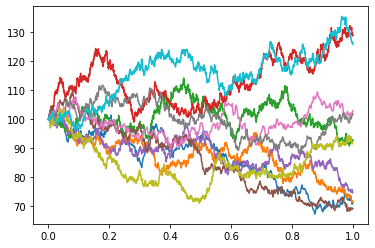

In [0]:
S = 100.
E = 100.
sigma = 0.2 # volatility  = 20%
r_rate = 0.05 # constant risk-free interest rate r = 5%
T = 1

M = 1 # step size for EM method to take
N = 2000 # number of steps for Brownian Motion

for i in range(10):
  M = random.randint(1,4)
  N = random.randint(1000, 3000)
  b = generate_brownian_for(N)[1]

  EM = euler_maruyama_approximation(initial_S=S,
                                           riskfree_rate=r_rate,
                                           sigma=sigma,
                                           arr_brownian=b,
                                           T=T,
                                           n_time_steps=N,
                                           step_size=M
                                           )
  L = N/M
  time_EM = np.linspace(0.,1.,int(L+1))
  plt.plot(time_EM, EM)


In [0]:
@numba.njit(fastmath=True)
def EM_approximation(initial_S, riskfree_rate, sigma, T, n_time_steps, step_size):
    dt = 1./n_time_steps  # EM step size

    arr_brownian = np.random.normal(0., 1., int(n_time_steps * step_size))*np.sqrt(dt)  # genearate for each time step

    prev_S = initial_S
    curr_S = 0         
    for i in range(0,n_time_steps):
      start_idx = step_size*(i-1)+step_size
      end_idx = step_size*i + step_size
      Winc = np.sum(arr_brownian[start_idx : end_idx])

      curr_S = prev_S + prev_S * riskfree_rate * dt + prev_S * sigma * Winc
      prev_S = curr_S
    return curr_S

In [0]:
@np.vectorize
def EM_simulation(S=100., K=100., sigma=0.2, r_rate=0.05, T=1, N=1000, M=1, n_simulations=500):
    em_vec = np.vectorize(EM_approximation)(np.full(n_simulations,S), r_rate, sigma, T, N,M)

    hvside_call = np.where(em_vec-K >= 0,1,0)
    hvside_put = np.where(em_vec-K <= 0,1,0)
    
    payoffs_call = np.sum(hvside_call) / float(n_simulations)
    payoffs_put = np.sum(hvside_put) / float(n_simulations)
    
    option_price_call = exp(-r_rate * T) * payoffs_call
    option_price_put = exp(-r_rate * T) * payoffs_put

    return option_price_call, option_price_put


In [0]:
S = 100.
K = 100.
sigma = 0.2 # volatility  = 20%
r_rate = 0.05 # constant risk-free interest rate r = 5%
T = 1

M = 1 # step size for EM method to take
N = 1000# number of steps for Brownian Motion

n_simulations = [500, 1000, 1500, 2000, 5000, 10000, 20000, 40000]

print("going to run {} of simlations".format(len(n_simulations)))
for idx, i in enumerate(n_simulations):
  print("simulation: {} with {} iterations".format(idx+1, i))


going to run 8 of simlations
simulation: 1 with 500 iterations
simulation: 2 with 1000 iterations
simulation: 3 with 1500 iterations
simulation: 4 with 2000 iterations
simulation: 5 with 5000 iterations
simulation: 6 with 10000 iterations
simulation: 7 with 20000 iterations
simulation: 8 with 40000 iterations


In [0]:
results = EM_simulation(S, K, sigma, r_rate, T, N, M, n_simulations)
cols = ['sim_{}'.format(i) for i in n_simulations]
df = pd.DataFrame(results, columns=cols)
df = df.T
df.columns=["call", "put"]
df

,call,put
sim_500,0.513664,0.437566
sim_1000,0.530786,0.420443
sim_1500,0.547908,0.403321
sim_2000,0.534115,0.417114
sim_5000,0.532118,0.419112
sim_10000,0.529074,0.422156
sim_20000,0.528979,0.422251
sim_40000,0.530287,0.420943


---
Checking results
with $\underline{Black Scholes}$ model:

$\hspace 4em C={e}^{−rT}  \Phi(d2)$

$\hspace 4em P={e}^{−rT} \Phi(-d2)$

$\hspace 4em$ Where $\Phi$ is the cumulative normal distribution function

$\hspace 4em$ and $d2 = \frac{log(\frac{S}{K}) + (r - \frac{1}{2}{\sigma}^2)T}{\sigma\sqrt{T}} $ 

---

In [0]:
d2 = (log(S/K) + (r_rate - 0.5 * sigma**2) * T) / sigma*sqrt(T)
call = exp(-r_rate * T) * norm.cdf(d2)
put = exp(-r_rate * T) * norm.cdf(-d2)

df["BS_call"] = call
df["BS_put"] = put
df["err_call"] = (abs(df.call-df.BS_call)/df.BS_call) * 100
df["err_put"] = (abs(df.put-df.BS_put)/df.BS_put) * 100

df

,call,put,BS_call,BS_put,err_call,err_put
sim_500,0.513664,0.437566,0.532325,0.418905,3.505553,4.454696
sim_1000,0.530786,0.420443,0.532325,0.418905,0.289071,0.367338
sim_1500,0.547908,0.403321,0.532325,0.418905,2.927411,3.720019
sim_2000,0.534115,0.417114,0.532325,0.418905,0.336356,0.427426
sim_5000,0.532118,0.419112,0.532325,0.418905,0.038900,0.049433
sim_10000,0.529074,0.422156,0.532325,0.418905,0.610719,0.776074
sim_20000,0.528979,0.422251,0.532325,0.418905,0.628588,0.798781
sim_40000,0.530287,0.420943,0.532325,0.418905,0.382885,0.486553


In [0]:
import plotly.graph_objects as go

layout = go.Layout(autosize=True, width=700, height=400,
                   font={"family": "Raleway", "size": 10},
                   margin={ "r": 30, "t": 30, "b": 30, "l": 30, },
                   showlegend=True,
                   titlefont={ "family": "Raleway", "size": 10, }
                   )

fig = go.Figure(layout=layout)
s_list = "err_call err_put".split()

fig.add_traces( [go.Scatter(x=df.index, y=df[col],
                    mode='lines+markers',
                    name=col) for col in s_list]
               )

fig.show()

## Step 2: Conclusions
 
The first step here was to calculate an exact set of option values through the analytical method using the Black-Scholes Model to benchmark our results from the simulations. Several Monte Carlo simulations were then run using the Forward Euler-Maruyama method to evaluate the accuracy and precision of our model.

The Euler-Maruyama methodology did not show converinging error reduction with an increase in  the simulation size. However at $N = 5000$ yielded a value as accurate and exact up to three decimal places($V = 0.532118$) for Binary Call Option and two decimal places ($V = 0.419112$) for Binary Put Option

Beyond 5000 simulations and up to 40,000 the error percent ranged from $0.0389%$ and $0.628588$ for the digital Call Option value and $0.049433$ and $0.798781$ for the digital Put Option value